In [74]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
from typing import Tuple

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
palette = itertools.cycle(sns.color_palette())

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
)

## 1. Initial Processing

In [2]:
# Set your own path
path = 'data/CA_final.csv'

df = pd.read_csv(path)
df.head()

In [4]:
len(df)

1741433

We've got 1.7M accident records in CA.

In [5]:
df.groupby('Year')['ID'].size()

Year
2016    140452
2017    152748
2018    156898
2019    213455
2020    285532
2021    341876
2022    375913
2023     74559
Name: ID, dtype: int64

In [7]:
df_2022 = df[df['Year'] == 2022]
df_2022.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Hour,Minute,Wind_Speed(mph)_Imputed,Humidity(%)_Imputed,Temperature(F)_Imputed,Visibility(mi)_Imputed,Pressure(in)_Imputed,geohash4,Wind_Direction_Imputed,Weather_Condition_Imputed
175167,A-512231,Source2,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,NaN,NaN,0.0,...,2,2,6.0,28.0,86.0,10.0,27.35,9qhh,E,Thunderstorms and Rain
175168,A-512257,Source2,1,2022-09-08 02:02:58,2022-09-08 02:32:20,34.177322,-118.877014,NaN,NaN,0.0,...,2,2,3.0,87.0,68.0,9.0,29.78,9q56,WNW,Thunderstorms and Rain
175169,A-512277,Source2,3,2022-09-07 21:54:19,2022-09-07 22:38:20,38.593945,-121.504059,NaN,NaN,0.0,...,21,54,0.0,28.0,83.0,10.0,29.83,9qce,VAR,Thunderstorms and Rain
175170,A-512340,Source2,2,2022-09-08 02:03:43,2022-09-08 02:33:13,33.850147,-117.875938,NaN,NaN,0.0,...,2,3,0.0,66.0,79.0,10.0,29.76,9qh0,VAR,Thunderstorms and Rain
175171,A-512341,Source3,1,2022-09-08 02:30:59,2022-09-08 03:00:27,33.884056,-118.029007,NaN,NaN,0.0,...,2,30,0.0,66.0,78.0,10.0,29.74,9qh0,VAR,Thunderstorms and Rain


In [8]:
df_2022['Start_Time'].min(), df_2022['Start_Time'].max()

('2022-01-01 00:02:00', '2022-12-31 23:59:00')

In [11]:
# Saving data for 2022 to lighten memory.
save_path = 'data/data_2022.csv'
df_2022.to_csv(save_path)

If you have already saved data for 2022 start here

In [3]:
# Load 2022 data
load_path = 'data/data_2022.csv'
df = pd.read_csv(load_path)

In [4]:
len(df)

375913

In [16]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])

In [5]:
# Creating a time range with index representing consecutive hours in 2022
start_time = pd.Timestamp('2022-01-01 00:00:00')
end_time = pd.Timestamp('2022-12-31 23:00:00')
hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')
hourly_df = pd.DataFrame(hourly_range, columns=['hour'])
hourly_df['hour_index'] = range(1, len(hourly_range) + 1)


C:\Users\balda\AppData\Local\Temp\ipykernel_20292\2312101316.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')


In [6]:
hourly_df.head()

,hour,hour_index
0,2022-01-01 00:00:00,1
1,2022-01-01 01:00:00,2
2,2022-01-01 02:00:00,3
3,2022-01-01 03:00:00,4
4,2022-01-01 04:00:00,5


In [24]:
len(hourly_df)

8760

In [7]:
geohashes = df['geohash5'].unique()
multi_index = pd.MultiIndex.from_product([hourly_range, geohashes], names=['hour', 'geohash5'])
multi_index_df = pd.DataFrame(index=multi_index).reset_index()

In [8]:
multi_index_df.head()

,hour,geohash5
0,2022-01-01,9qhh7
1,2022-01-01,9q56q
2,2022-01-01,9qcee
3,2022-01-01,9qh0t
4,2022-01-01,9qh0f


In [57]:
# Step 6: Count accidents per hour and geohash
accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')

# Step 7: Merge the multi-index DataFrame with the accident counts
merged_df = pd.merge(multi_index_df, accident_counts, how='left', left_on=['hour', 'geohash5'], right_on=['Start_Time', 'geohash5'])

C:\Users\balda\AppData\Local\Temp\ipykernel_20292\3631858385.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')


Let's add one_hot_encoded features for hour of the day and day of the week.

In [58]:
merged_df = merged_df.drop(columns=['Start_Time']).fillna(value=0)

# Assuming 'df' is your DataFrame with the structure you provided
# If not already in datetime format, ensure 'hour' is in datetime format
merged_df['hour'] = pd.to_datetime(merged_df['hour'])

# Step 1: Extract hour of the day and day of the week
merged_df['hour_of_day'] = merged_df['hour'].dt.hour
merged_df['day_of_week'] = merged_df['hour'].dt.dayofweek  # Monday=0, Sunday=6

# Step 2: Generate one-hot encoded columns
hour_dummies = pd.get_dummies(merged_df['hour_of_day'], prefix='hour')
day_dummies = pd.get_dummies(merged_df['day_of_week'], prefix='day')

# Step 3: Concatenate these new columns to the original DataFrame
merged_df = pd.concat([merged_df, hour_dummies, day_dummies], axis=1)

# Display the final DataFrame
print(merged_df)

                        hour geohash5  accident_count  hour_of_day  \
0        2022-01-01 00:00:00    9qhh7             0.0            0   
1        2022-01-01 00:00:00    9q56q             1.0            0   
2        2022-01-01 00:00:00    9qcee             0.0            0   
3        2022-01-01 00:00:00    9qh0t             0.0            0   
4        2022-01-01 00:00:00    9qh0f             0.0            0   
...                      ...      ...             ...          ...   
63448675 2022-12-31 23:00:00    9r4rr             0.0           23   
63448676 2022-12-31 23:00:00    9r354             0.0           23   
63448677 2022-12-31 23:00:00    9r3q8             0.0           23   
63448678 2022-12-31 23:00:00    9r4n7             0.0           23   
63448679 2022-12-31 23:00:00    9r0wf             0.0           23   

          day_of_week  hour_0  hour_1  hour_2  hour_3  hour_4  ...  hour_21  \
0                   5    True   False   False   False   False  ...    False   
1

There's a lot of hashes and a lot of hours so let's take just one hash for now and try to model it. Going for hash `9q5cw` - one with the most accidents in 2022.

In [180]:
merged_df.to_csv('data/merged_df.csv')

In [2]:
merged_df = pd.read_csv('data/merged_df.csv', index_col=[0])

In [21]:
one_hash_df = merged_df[merged_df['geohash5'] == '9q5cw']

In [22]:
one_hash_df['accident_bool'] = (one_hash_df['accident_count'] > 0)

C:\Users\balda\AppData\Local\Temp\ipykernel_35152\2651838735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_hash_df['accident_bool'] = (one_hash_df['accident_count'] > 0)


In [23]:
one_hash_df

,hour,geohash5,accident_count,hour_of_day,day_of_week,hour_0,hour_1,hour_2,hour_3,hour_4,...,hour_22,hour_23,day_0,day_1,day_2,day_3,day_4,day_5,day_6,accident_bool
116,2022-01-01,9q5cw,0.0,0,5,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
7359,2022-01-01 01:00:00,9q5cw,0.0,1,5,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
14602,2022-01-01 02:00:00,9q5cw,0.0,2,5,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
21845,2022-01-01 03:00:00,9q5cw,2.0,3,5,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
29088,2022-01-01 04:00:00,9q5cw,0.0,4,5,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63412581,2022-12-31 19:00:00,9q5cw,4.0,19,5,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
63419824,2022-12-31 20:00:00,9q5cw,3.0,20,5,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
63427067,2022-12-31 21:00:00,9q5cw,0.0,21,5,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
63434310,2022-12-31 22:00:00,9q5cw,7.0,22,5,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,True


## 2. Training

The code I am using here is from exercise 06 Part 2.

In [24]:
# Define target
y = np.array(one_hash_df['accident_bool'])
X = np.array(one_hash_df.drop(columns=['hour', 'geohash5', 'accident_count', 'hour_of_day', 'day_of_week', 'accident_bool']))

# Split into train and test
N = len(X)
split_idx = int(0.85*N)
X_train = X[:split_idx,:]
y_train = y[:split_idx]
X_test = X[split_idx:,:]
y_test = y[split_idx:]

print(' X_train:', X_train.shape, '\n', 'X_test:', X_test.shape, '\n', 'y_train:', y_train.shape, '\n', 'y_test:', y_test.shape)

 X_train: (7446, 31) 
 X_test: (1314, 31) 
 y_train: (7446,) 
 y_test: (1314,)


In [40]:
# code taken from https://towardsdatascience.com/bayesian-logistic-regression-in-python-9fae6e6e3e6a
def logistic_regression_model(features, target):
    # Generate priors
    weight = pyro.sample(
        "weight", dist.Normal(torch.zeros(1, features.shape[1]), torch.ones(1, features.shape[1])).independent(1)
    )
    bias = pyro.sample(
        "bias", dist.Normal(torch.zeros(1), torch.ones(1))
    )
    with pyro.plate("data", features.size(0)):
        # Generate raw model logits
        model_logits = (torch.matmul(features, weight.permute(1, 0)) + bias).squeeze()
        # Apply sigmoid function
        probs = torch.sigmoid(model_logits)
        pyro.sample(
            "obs", 
            dist.Bernoulli(probs=probs),
            obs=target.squeeze()
        )

In [41]:
def run_inference(features: torch.Tensor, target: torch.Tensor, number_of_samples: int, number_of_chains:int) -> MCMC:
    # Initialise NUTS sampler
    kernel = NUTS(logistic_regression_model)
    # Initialise MCMC class
    mcmc = MCMC(kernel, num_samples = number_of_samples, warmup_steps = 200, num_chains=number_of_chains)
    # Run sampling
    mcmc.run(features.float(), target.float())
    return mcmc

In [42]:
inference = run_inference(features=X_train, target=y_train, number_of_samples=3000, number_of_chains=1)

Sample: 100%|██████████| 3200/3200 [04:28, 11.91it/s, step size=8.83e-02, acc. prob=0.946]


In [45]:
summary = inference.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     bias[0]     -1.21      0.37     -1.20     -1.84     -0.63    162.30      1.00
 weight[0,0]     -0.40      0.25     -0.41     -0.79      0.03    220.71      1.01
 weight[0,1]     -0.93      0.28     -0.92     -1.37     -0.47    268.23      1.01
 weight[0,2]     -1.00      0.28     -0.99     -1.47     -0.55    248.04      1.01
 weight[0,3]     -0.92      0.28     -0.92     -1.40     -0.48    249.82      1.01
 weight[0,4]     -1.12      0.29     -1.13     -1.61     -0.69    284.40      1.01
 weight[0,5]      0.42      0.24      0.42      0.04      0.83    185.90      1.02
 weight[0,6]      0.58      0.24      0.58      0.15      0.95    186.61      1.01
 weight[0,7]      0.26      0.24      0.25     -0.09      0.68    186.13      1.01
 weight[0,8]      0.17      0.24      0.17     -0.22      0.57    191.63      1.01
 weight[0,9]      0.15      0.25      0.15     -0.23      0.59    199.20      1.01
wei

In [46]:
samples = inference.get_samples()

In [62]:
samples['weight'][:,:,0].shape

torch.Size([3000, 1])

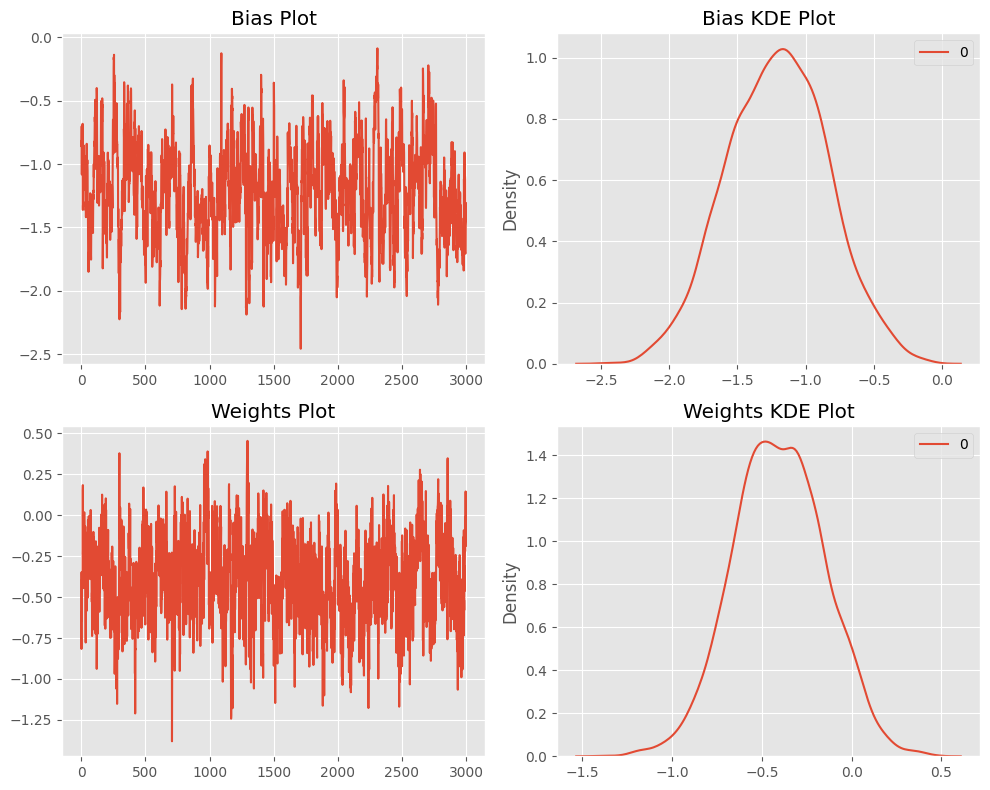

In [63]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot samples['bias'] on the first subplot
axs[0, 0].plot(samples['bias'])
axs[0, 0].set_title('Bias Plot')

# Plot KDE plot of samples['bias'] on the second subplot
sns.kdeplot(samples['bias'], ax=axs[0, 1])
axs[0, 1].set_title('Bias KDE Plot')

# Plot samples['weights'] on the third subplot
axs[1, 0].plot(samples['weight'][:,:,0])
axs[1, 0].set_title('Weights Plot')

# Plot KDE plot of samples['weights'] on the fourth subplot
sns.kdeplot(samples['weight'][:,:,0], ax=axs[1, 1])
axs[1, 1].set_title('Weights KDE Plot')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [82]:
samples["weight"][0].permute(1, 0).shape

torch.Size([31, 1])

In [86]:
X_test

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False]])

In [88]:
def create_predictions(samples: dict, dataset: torch.tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # Create tensor of zeros with shape (number of samples x number of examples)
    obs_samples = torch.zeros(samples["weight"].shape[0], dataset.shape[0])
    # Iterate through every set of samples
    for i in range(samples["weight"].shape[0]):
        W_sample = samples["weight"][i]
        b_sample = samples["bias"][i]

        model_logits = (torch.matmul(dataset, W_sample.permute(1, 0)) + b_sample).squeeze()
        probs = torch.sigmoid(model_logits)

        obs_samples[i] = probs
    # Calculate the mean prediction per example
    mean_predictions = obs_samples.mean(dim=0)
    # Classify the prediction
    class_predictions = (obs_samples.mean(dim=0)>0.5).int()

    return class_predictions, obs_samples, mean_predictions

In [90]:
class_predictions, obs_samples, mean_predictions = create_predictions(samples=samples, dataset=torch.tensor(X_test).float())

In [93]:
def calculate_classification_metrics(
    true_labels: torch.Tensor, predicted_labels: torch.Tensor, prob_scores: torch.Tensor
) -> dict:
    metrics = {}

    # Accuracy
    metrics["Accuracy"] = accuracy_score(true_labels, predicted_labels)

    # Precision
    metrics["Precision"] = precision_score(true_labels, predicted_labels)

    # Recall
    metrics["Recall"] = recall_score(true_labels, predicted_labels)

    # F1 Score
    metrics["F1 Score"] = f1_score(true_labels, predicted_labels)

    # Confusion Matrix
    metrics["Confusion Matrix"] = confusion_matrix(true_labels, predicted_labels)

    # ROC Curve
    metrics["ROC Score"] = roc_curve(true_labels, prob_scores)

    # AUC-ROC
    metrics["AUC-ROC"] = roc_auc_score(true_labels, prob_scores)

    return metrics

In [94]:
calculate_classification_metrics(
    true_labels=y_test, predicted_labels=class_predictions, prob_scores=mean_predictions
)

c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.7922374429223744,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1 Score': 0.0,
 'Confusion Matrix': array([[1041,    0],
        [ 273,    0]], dtype=int64),
 'ROC Score': (array([0.        , 0.00384246, 0.00864553, 0.01633045, 0.02209414,
         0.02881844, 0.03458213, 0.03842459, 0.04418828, 0.05091258,
         0.05667627, 0.06051873, 0.06532181, 0.07204611, 0.0778098 ,
         0.07973103, 0.08549472, 0.09317963, 0.09990394, 0.10566763,
         0.11239193, 0.117195  , 0.12199808, 0.12584054, 0.13160423,
         0.13544669, 0.13832853, 0.14601345, 0.15081652, 0.15754083,
         0.1623439 , 0.16810759, 0.17483189, 0.1815562 , 0.18539866,
         0.19116234, 0.19788665, 0.20365034, 0.21037464, 0.21613833,
         0.24303554, 0.25072046, 0.26032661, 0.26705091, 0.2728146 ,
         0.27761768, 0.28338136, 0.29010567, 0.29490874, 0.2987512 ,
         0.30451489, 0.30931796, 0.33237272, 0.33909702, 0.3439001 ,
         0.35542747, 0.36023055, 0.36503362, 0.37079731, 0.3784

In [26]:
def model(X, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1), 
                                             5.*torch.ones(1)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim), 
                                            5.*torch.ones(input_dim)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Bernoulli(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [27]:
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [30]:
y_train

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [31]:
y

array([False, False, False, ..., False,  True, False])

In [28]:
X_train.shape, y_train.shape

(torch.Size([7446, 31]), torch.Size([7446]))

In [29]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 40000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train-1)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

ValueError: Error while computing log_prob at site 'y':
Expected value argument (Tensor of shape (7446,)) to be within the support (Boolean()) of the distribution Bernoulli(logits: torch.Size([7446])), but found invalid values:
tensor([-1., -1., -1.,  ..., -1., -1., -1.])
Trace Shapes:          
 Param Sites:          
Sample Sites:          
   alpha dist      |  1
        value      |  1
     log_prob      |   
    beta dist      | 31
        value      | 31
     log_prob      |   
       y dist 7446 |   
        value 7446 |   